In [1]:
from IPython.display import HTML
HTML("""
<style>
h1,h2,h3 {
	margin: 1em 0 0.5em 0;
	font-weight: 600;
	font-family: 'Titillium Web', sans-serif;
	position: relative;  
	font-size: 36px;
	line-height: 40px;
	padding: 15px 15px 15px 2.5%;
	color: #13003A;
	box-shadow: 
		inset 0 0 0 1px rgba(53,86,129, 1), 
		inset 0 0 5px rgba(53,86,129, 1),
		inset -250px 0 35px #FADFFF;
	border-radius: 0 10px 0 15px;
	background: #fff
    
}
</style>
""")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import plotly.graph_objs as go
from geopy.geocoders import Nominatim
import folium
from folium.plugins import HeatMap
from folium.plugins import FastMarkerCluster
from plotly import tools
import re
from plotly.offline import init_notebook_mode, plot, iplot
from wordcloud import WordCloud, STOPWORDS 
from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
df=pd.read_csv("/kaggle/input/zomato-bangalore-restaurants/zomato.csv")

# Basic Exploration

In [4]:
df.head()

url  \
0  https://www.zomato.com/bangalore/jalsa-banasha...   
1  https://www.zomato.com/bangalore/spice-elephan...   
2  https://www.zomato.com/SanchurroBangalore?cont...   
3  https://www.zomato.com/bangalore/addhuri-udupi...   
4  https://www.zomato.com/bangalore/grand-village...   

                                             address                   name  \
0  942, 21st Main Road, 2nd Stage, Banashankari, ...                  Jalsa   
1  2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...         Spice Elephant   
2  1112, Next to KIMS Medical College, 17th Cross...        San Churro Cafe   
3  1st Floor, Annakuteera, 3rd Stage, Banashankar...  Addhuri Udupi Bhojana   
4  10, 3rd Floor, Lakshmi Associates, Gandhi Baza...          Grand Village   

  online_order book_table   rate  votes                             phone  \
0          Yes        Yes  4.1/5    775    080 42297555\r\n+91 9743772233   
1          Yes         No  4.1/5    787                      080 41714161   
2          Yes         No  3.8/5    918                    +91 9663487993   
3           No         No  3.7/5     88                    +91 9620009302   
4           No         No  3.8/5    166  +91 8026612447\r\n+91 9901210005   

       location            rest_type  \
0  Banashankari        Casual Dining   
1  Banashankari        Casual Dining   
2  Banashankari  Cafe, Casual Dining   
3  Banashankari          Quick Bites   
4  Basavanagudi        Casual Dining   

                                          dish_liked  \
0  Pasta, Lunch Buffet, Masala Papad, Paneer Laja...   
1  Momos, Lunch Buffet, Chocolate Nirvana, Thai G...   
2  Churros, Cannelloni, Minestrone Soup, Hot Choc...   
3                                        Masala Dosa   
4                                Panipuri, Gol Gappe   

                         cuisines approx_cost(for two people)  \
0  North Indian, Mughlai, Chinese                         800   
1     Chinese, North Indian, Thai                         800   
2          Cafe, Mexican, Italian                         800   
3      South Indian, North Indian                         300   
4        North Indian, Rajasthani                         600   

                                        reviews_list menu_item  \
0  [('Rated 4.0', 'RATED\n  A beautiful place to ...        []   
1  [('Rated 4.0', 'RATED\n  Had been here for din...        []   
2  [('Rated 3.0', "RATED\n  Ambience is not that ...        []   
3  [('Rated 4.0', "RATED\n  Great food and proper...        []   
4  [('Rated 4.0', 'RATED\n  Very good restaurant ...        []   

  listed_in(type) listed_in(city)  
0          Buffet    Banashankari  
1          Buffet    Banashankari  
2          Buffet    Banashankari  
3          Buffet    Banashankari  
4          Buffet    Banashankari

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51717 entries, 0 to 51716
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   url                          51717 non-null  object
 1   address                      51717 non-null  object
 2   name                         51717 non-null  object
 3   online_order                 51717 non-null  object
 4   book_table                   51717 non-null  object
 5   rate                         43942 non-null  object
 6   votes                        51717 non-null  int64 
 7   phone                        50509 non-null  object
 8   location                     51696 non-null  object
 9   rest_type                    51490 non-null  object
 10  dish_liked                   23639 non-null  object
 11  cuisines                     51672 non-null  object
 12  approx_cost(for two people)  51371 non-null  object
 13  reviews_list                 51

In [6]:
df.isna().sum()

url                                0
address                            0
name                               0
online_order                       0
book_table                         0
rate                            7775
votes                              0
phone                           1208
location                          21
rest_type                        227
dish_liked                     28078
cuisines                          45
approx_cost(for two people)      346
reviews_list                       0
menu_item                          0
listed_in(type)                    0
listed_in(city)                    0
dtype: int64

In [7]:
df.describe().T

count        mean         std  min  25%   50%    75%      max
votes  51717.0  283.697527  803.838853  0.0  7.0  41.0  198.0  16832.0

In [8]:
df.dropna(axis=0,subset=['location'],inplace=True)

In [9]:
len(df['location'].unique())

93

In [10]:
locations=pd.DataFrame({"Name":df['location'].unique()})

In [11]:
locations.head()

Name
0        Banashankari
1        Basavanagudi
2         Mysore Road
3           Jayanagar
4  Kumaraswamy Layout

# Geospatial Analysis

In [12]:
geolocator=Nominatim(user_agent="app")

In [13]:
lat=[]
lon=[]
for location in locations['Name']:
    location = geolocator.geocode(location)    
    if location is None:
        lat.append(np.nan)
        lon.append(np.nan)
    else:
        lat.append(location.latitude)
        lon.append(location.longitude)

In [14]:
locations['lat']=lat
locations['lon']=lon

In [15]:
locations.head()

Name        lat        lon
0        Banashankari  15.887678  75.704678
1        Basavanagudi  12.941726  77.575502
2         Mysore Road  12.946662  77.530090
3           Jayanagar  27.643927  83.052805
4  Kumaraswamy Layout  12.908149  77.555318

In [16]:
Rest_locations=pd.DataFrame(df['location'].value_counts().reset_index())

In [17]:
Rest_locations.columns=['Name','count']
Rest_locations.head()

Name  count
0                    BTM   5124
1                    HSR   2523
2  Koramangala 5th Block   2504
3               JP Nagar   2235
4             Whitefield   2144

In [18]:
print(locations.shape)
print(Rest_locations.shape)

(93, 3)
(93, 2)


In [19]:
Restaurant_locations=Rest_locations.merge(locations,on='Name',how="left").dropna()
Restaurant_locations.head()

Name  count        lat         lon
0                    BTM   5124  45.954851 -112.496595
1                    HSR   2523  18.147500   41.538889
2  Koramangala 5th Block   2504  12.934843   77.618977
3               JP Nagar   2235  12.265594   76.646540
4             Whitefield   2144  53.553368   -2.296902

In [20]:
Restaurant_locations['count'].max()

5124

In [21]:
#### Bengaluru Coordinates - (12.9716° N, 77.5946° E)
def generateBaseMap(default_location=[12.97, 77.59], default_zoom_start=12):
    base_map = folium.Map(location=default_location, zoom_start=default_zoom_start)
    return base_map

In [22]:
basemap=generateBaseMap()

# Base Map of Bengaluru

In [23]:
basemap

In [24]:
Restaurant_locations[['lat','lon','count']]

lat         lon  count
0   45.954851 -112.496595   5124
1   18.147500   41.538889   2523
2   12.934843   77.618977   2504
3   12.265594   76.646540   2235
4   53.553368   -2.296902   2144
..        ...         ...    ...
88  12.984852   77.540063      6
89  13.100698   77.596345      6
90  13.078474   77.606894      3
91  12.927441   77.515522      2
92  13.032942   77.527325      1

[92 rows x 3 columns]

In [25]:
HeatMap(Restaurant_locations[['lat','lon','count']],zoom=20,radius=15).add_to(basemap)

# Heatmap for Restaurants in Begaluru

In [26]:
basemap

# Marker Cluster Map for restaurants in Bengaluru

In [27]:
FastMarkerCluster(data=Restaurant_locations[['lat','lon','count']].values.tolist()).add_to(basemap)

basemap

# Marker Cluster Map according to average ratings of Restaurants

In [28]:
df['rate'].unique()

array(['4.1/5', '3.8/5', '3.7/5', '3.6/5', '4.6/5', '4.0/5', '4.2/5',
       '3.9/5', '3.1/5', '3.0/5', '3.2/5', '3.3/5', '2.8/5', '4.4/5',
       '4.3/5', 'NEW', '2.9/5', '3.5/5', nan, '2.6/5', '3.8 /5', '3.4/5',
       '4.5/5', '2.5/5', '2.7/5', '4.7/5', '2.4/5', '2.2/5', '2.3/5',
       '3.4 /5', '-', '3.6 /5', '4.8/5', '3.9 /5', '4.2 /5', '4.0 /5',
       '4.1 /5', '3.7 /5', '3.1 /5', '2.9 /5', '3.3 /5', '2.8 /5',
       '3.5 /5', '2.7 /5', '2.5 /5', '3.2 /5', '2.6 /5', '4.5 /5',
       '4.3 /5', '4.4 /5', '4.9/5', '2.1/5', '2.0/5', '1.8/5', '4.6 /5',
       '4.9 /5', '3.0 /5', '4.8 /5', '2.3 /5', '4.7 /5', '2.4 /5',
       '2.1 /5', '2.2 /5', '2.0 /5', '1.8 /5'], dtype=object)

In [29]:
df.dropna(axis=0,subset=['rate'],inplace=True)

In [30]:
df['rate'].unique()

array(['4.1/5', '3.8/5', '3.7/5', '3.6/5', '4.6/5', '4.0/5', '4.2/5',
       '3.9/5', '3.1/5', '3.0/5', '3.2/5', '3.3/5', '2.8/5', '4.4/5',
       '4.3/5', 'NEW', '2.9/5', '3.5/5', '2.6/5', '3.8 /5', '3.4/5',
       '4.5/5', '2.5/5', '2.7/5', '4.7/5', '2.4/5', '2.2/5', '2.3/5',
       '3.4 /5', '-', '3.6 /5', '4.8/5', '3.9 /5', '4.2 /5', '4.0 /5',
       '4.1 /5', '3.7 /5', '3.1 /5', '2.9 /5', '3.3 /5', '2.8 /5',
       '3.5 /5', '2.7 /5', '2.5 /5', '3.2 /5', '2.6 /5', '4.5 /5',
       '4.3 /5', '4.4 /5', '4.9/5', '2.1/5', '2.0/5', '1.8/5', '4.6 /5',
       '4.9 /5', '3.0 /5', '4.8 /5', '2.3 /5', '4.7 /5', '2.4 /5',
       '2.1 /5', '2.2 /5', '2.0 /5', '1.8 /5'], dtype=object)

In [31]:
def split(x):
    return x.split('/')[0]

In [32]:
df['rating']=df['rate'].apply(split)
df['rating'].unique()

array(['4.1', '3.8', '3.7', '3.6', '4.6', '4.0', '4.2', '3.9', '3.1',
       '3.0', '3.2', '3.3', '2.8', '4.4', '4.3', 'NEW', '2.9', '3.5',
       '2.6', '3.8 ', '3.4', '4.5', '2.5', '2.7', '4.7', '2.4', '2.2',
       '2.3', '3.4 ', '-', '3.6 ', '4.8', '3.9 ', '4.2 ', '4.0 ', '4.1 ',
       '3.7 ', '3.1 ', '2.9 ', '3.3 ', '2.8 ', '3.5 ', '2.7 ', '2.5 ',
       '3.2 ', '2.6 ', '4.5 ', '4.3 ', '4.4 ', '4.9', '2.1', '2.0', '1.8',
       '4.6 ', '4.9 ', '3.0 ', '4.8 ', '2.3 ', '4.7 ', '2.4 ', '2.1 ',
       '2.2 ', '2.0 ', '1.8 '], dtype=object)

In [33]:
df.replace('NEW',0,inplace=True)
df.replace('-',0,inplace=True)

In [34]:
df['rating']=pd.to_numeric(df['rating'])
df.groupby(['location'])['rating'].mean().sort_values(ascending=False)

location
Lavelle Road             4.042886
St. Marks Road           4.017201
Koramangala 3rd Block    3.978756
Sankey Road              3.965385
Church Street            3.963091
                           ...   
Electronic City          3.041909
Bommanahalli             2.926752
Hebbal                   2.880000
North Bangalore          2.385714
West Bangalore           2.020000
Name: rating, Length: 92, dtype: float64

In [35]:
df.groupby(['location'])['rating'].mean()

location
BTM                  3.296128
Banashankari         3.373292
Banaswadi            3.362926
Bannerghatta Road    3.271677
Basavanagudi         3.478185
                       ...   
West Bangalore       2.020000
Whitefield           3.384170
Wilson Garden        3.257635
Yelahanka            3.640000
Yeshwantpur          3.502679
Name: rating, Length: 92, dtype: float64

In [36]:
avg_rating=df.groupby(['location'])['rating'].mean().values

In [37]:
loc=df.groupby(['location'])['rating'].mean().index

In [38]:
geolocator=Nominatim(user_agent="app")

In [39]:
lat=[]
lon=[]
for location in loc:
    location = geolocator.geocode(location)    
    if location is None:
        lat.append(np.nan)
        lon.append(np.nan)
    else:
        lat.append(location.latitude)
        lon.append(location.longitude)

In [40]:
rating=pd.DataFrame()
rating['location']=loc
rating['lat']=lat
rating['lon']=lon
rating['avg_rating']=avg_rating

In [41]:
rating=rating.dropna()

In [42]:
HeatMap(rating[['lat','lon','avg_rating']],zoom=20,radius=15).add_to(basemap)
basemap

# Heatmap for Cuisines

In [43]:
df2= df[df['cuisines']=='North Indian']
df2.head()

url  \
5   https://www.zomato.com/bangalore/timepass-dinn...   
50  https://www.zomato.com/bangalore/petoo-banasha...   
72  https://www.zomato.com/bangalore/spicy-tandoor...   
87  https://www.zomato.com/bangalore/krishna-sagar...   
94  https://www.zomato.com/bangalore/nandhini-delu...   

                                              address             name  \
5   37, 5-1, 4th Floor, Bosco Court, Gandhi Bazaar...  Timepass Dinner   
50  276, Ground Floor, 100 Feet Outer Ring Road, B...            Petoo   
72  Opposite ICICi Bank, Hanuman Nagar, Banashanka...    Spicy Tandoor   
87  38, 22nd Main, 22nd Cross, Opposite BDA, 2nd S...    Krishna Sagar   
94  304, Opposite Apollo Public School, 100 Feet R...  Nandhini Deluxe   

   online_order book_table   rate  votes                             phone  \
5           Yes         No  3.8/5    286  +91 9980040002\r\n+91 9980063005   
50           No         No  3.7/5     21                    +91 8026893211   
72           No         No      0      0                    +91 8050884222   
87           No         No  3.5/5     31  +91 8892752997\r\n+91 7204780429   
94           No         No  2.6/5    283      080 26890011\r\n080 26890033   

        location      rest_type  \
5   Basavanagudi  Casual Dining   
50  Banashankari    Quick Bites   
72  Banashankari    Quick Bites   
87  Banashankari    Quick Bites   
94  Banashankari  Casual Dining   

                                           dish_liked      cuisines  \
5   Onion Rings, Pasta, Kadhai Paneer, Salads, Sal...  North Indian   
50                                                NaN  North Indian   
72                                                NaN  North Indian   
87                                                NaN  North Indian   
94  Biryani, Chicken Guntur, Thali, Buttermilk, Ma...  North Indian   

   approx_cost(for two people)  \
5                          600   
50                         450   
72                         150   
87                         200   
94                         600   

                                         reviews_list menu_item  \
5   [('Rated 3.0', 'RATED\n  Food 3/5\nAmbience 3/...        []   
50  [('Rated 2.0', 'RATED\n  This is a neatly made...        []   
72  [('Rated 4.0', 'RATED\n  cost for chicken roll...        []   
87  [('Rated 1.0', 'RATED\n  Worst experience with...        []   
94  [('Rated 3.0', 'RATED\n  Ididnt like much.\n\n...        []   

   listed_in(type) listed_in(city)  rating  
5           Buffet    Banashankari     3.8  
50        Delivery    Banashankari     3.7  
72        Delivery    Banashankari     0.0  
87        Delivery    Banashankari     3.5  
94        Delivery    Banashankari     2.6

In [44]:
north_india=df2.groupby('location')['url'].count().reset_index()
north_india.columns=['Name','count']
north_india.head()

Name  count
0                BTM    274
1       Banashankari     35
2          Banaswadi      9
3  Bannerghatta Road     60
4       Basavanagudi     17

In [45]:
north_india=north_india.merge(locations,on="Name",how='left').dropna()

In [46]:
basemap=generateBaseMap()
HeatMap(north_india[['lat','lon','count']].values.tolist(),zoom=20,radius=15).add_to(basemap)
basemap

In [47]:
def Heatmap_Zone(zone):
    df3=df[df['cuisines']==zone]
    df_zone=df3.groupby(['location'],as_index=False)['url'].agg('count')
    df_zone.columns=['Name','count']
    df_zone=df_zone.merge(locations,on="Name",how='left').dropna()
    basemap=generateBaseMap()
    HeatMap(df_zone[['lat','lon','count']].values.tolist(),zoom=20,radius=15).add_to(basemap)
    return basemap

In [48]:
df['cuisines'].unique()

array(['North Indian, Mughlai, Chinese', 'Chinese, North Indian, Thai',
       'Cafe, Mexican, Italian', ..., 'Tibetan, Nepalese',
       'North Indian, Street Food, Biryani',
       'North Indian, Chinese, Arabian, Momos'], dtype=object)

In [49]:
Heatmap_Zone('South Indian')

In [50]:
Heatmap_Zone('Italian')

In [51]:
df2=df.copy()

In [52]:
df = df.rename(columns={'approx_cost(for two people)':'cost','listed_in(type)':'type',
                                  'listed_in(city)':'city'})
df.columns

Index(['url', 'address', 'name', 'online_order', 'book_table', 'rate', 'votes',
       'phone', 'location', 'rest_type', 'dish_liked', 'cuisines', 'cost',
       'reviews_list', 'menu_item', 'type', 'city', 'rating'],
      dtype='object')

In [53]:
df['cost'] = df['cost'].astype(str)
df['cost'] = df['cost'].apply(lambda x: x.replace(',','.')) 
df['cost'] = df['cost'].astype(float)

In [54]:
df.name = df.name.apply(lambda x:x.title())
df.online_order.replace(('Yes','No'),(True, False),inplace=True)
df.book_table.replace(('Yes','No'),(True, False),inplace=True)

In [55]:
def Encode(data):
    for column in data.columns[~data.columns.isin(['rate', 'cost', 'votes','rating'])]:
        data[column] = data[column].factorize()[0]
    return data

Zom_df = Encode(df.copy())
Zom_df.head()

url  address  name  online_order  book_table   rate  votes  phone  \
0    0        0     0             0           0  4.1/5    775      0   
1    1        1     1             0           1  4.1/5    787      1   
2    2        2     2             0           1  3.8/5    918      2   
3    3        3     3             1           1  3.7/5     88      3   
4    4        4     4             1           1  3.8/5    166      4   

   location  rest_type  dish_liked  cuisines   cost  reviews_list  menu_item  \
0         0          0           0         0  800.0             0          0   
1         0          0           1         1  800.0             1          0   
2         0          1           2         2  800.0             2          0   
3         0          2           3         3  300.0             3          0   
4         1          0           4         4  600.0             4          0   

   type  city  rating  
0     0     0     4.1  
1     0     0     4.1  
2     0     0     3.8  
3     0     0     3.7  
4     0     0     3.8

# Is Online Delivering Available?

In [56]:
labels = ["Accepted",'Not Accepted']
values = df['online_order'].value_counts()
colors = ['mediumslateblue', 'darkorange']
fig = go.Figure(data=[go.Pie(labels=labels,
                             values=values,hole=.3)])
fig.update_traces(hoverinfo='label+percent', textinfo='value', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=3)))
fig.update_layout(title="Online delivering available? ",
                  titlefont={'size': 30},      
                  )
fig.show()

In [57]:
labels = ["Accepted",'Not Accepted']
values = df['book_table'].value_counts()
colors = ['mediumslateblue', 'darkorange']
fig = go.Figure(data=[go.Pie(labels=labels,
                             values=values,hole=.3)])
fig.update_traces(hoverinfo='label+percent', textinfo='value', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=3)))
fig.update_layout(title="Table booking available? ",
                  titlefont={'size': 30},
                  )
fig.show()

# Most popular Cuisines of Bengaluru

In [58]:
values = df['cuisines'].value_counts()[:20]
labels=values.index
text=values.index
fig = go.Figure(data=[go.Pie(values=values,labels=labels,hole=.3)])
fig.update_traces(hoverinfo='label+percent', textinfo='value', textfont_size=20,
                  marker=dict(line=dict(color='#000000', width=3)))
fig.update_layout(title="Most popular cuisines of Bangalore ",
                  titlefont={'size': 30},
                  )
fig.show()

In [59]:
fig = px.box(df,x='online_order',y='cost',color='online_order')

fig.update_layout(title="Cost comparison for Online order",
                  titlefont={'size': 30},template='simple_white'
                  )
fig.show()

In [60]:
dfupd=df.copy()
dfupd['update_dish_liked']=dfupd['dish_liked'].apply(lambda x : x.split(',') if type(x)==str else [''])
rest=dfupd['rest_type'].value_counts()[:9].index

In [61]:
dfupd.dropna(axis='index',subset=['rest_type'],inplace=True)
dfupd.dropna(axis='index',subset=['dish_liked'],inplace=True)

In [62]:
def produce_wordcloud(rest):
    
    plt.figure(figsize=(20,30))
    for i,restaurant in enumerate(rest):
        plt.subplot(3,3,i+1)
        dishes=''
        data=dfupd[dfupd['rest_type']==restaurant]
        for word in data['dish_liked']:
            words=word.split()
            # Converts each token into lowercase 
            for i in range(len(words)): 
                words[i] = words[i].lower() 
            dishes=dishes+ " ".join(words)+" "
        wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,stopwords = stopwords,width=1200, height=1200).generate(dishes)
        plt.imshow(wordcloud)
        plt.title(restaurant)
        plt.axis("off")

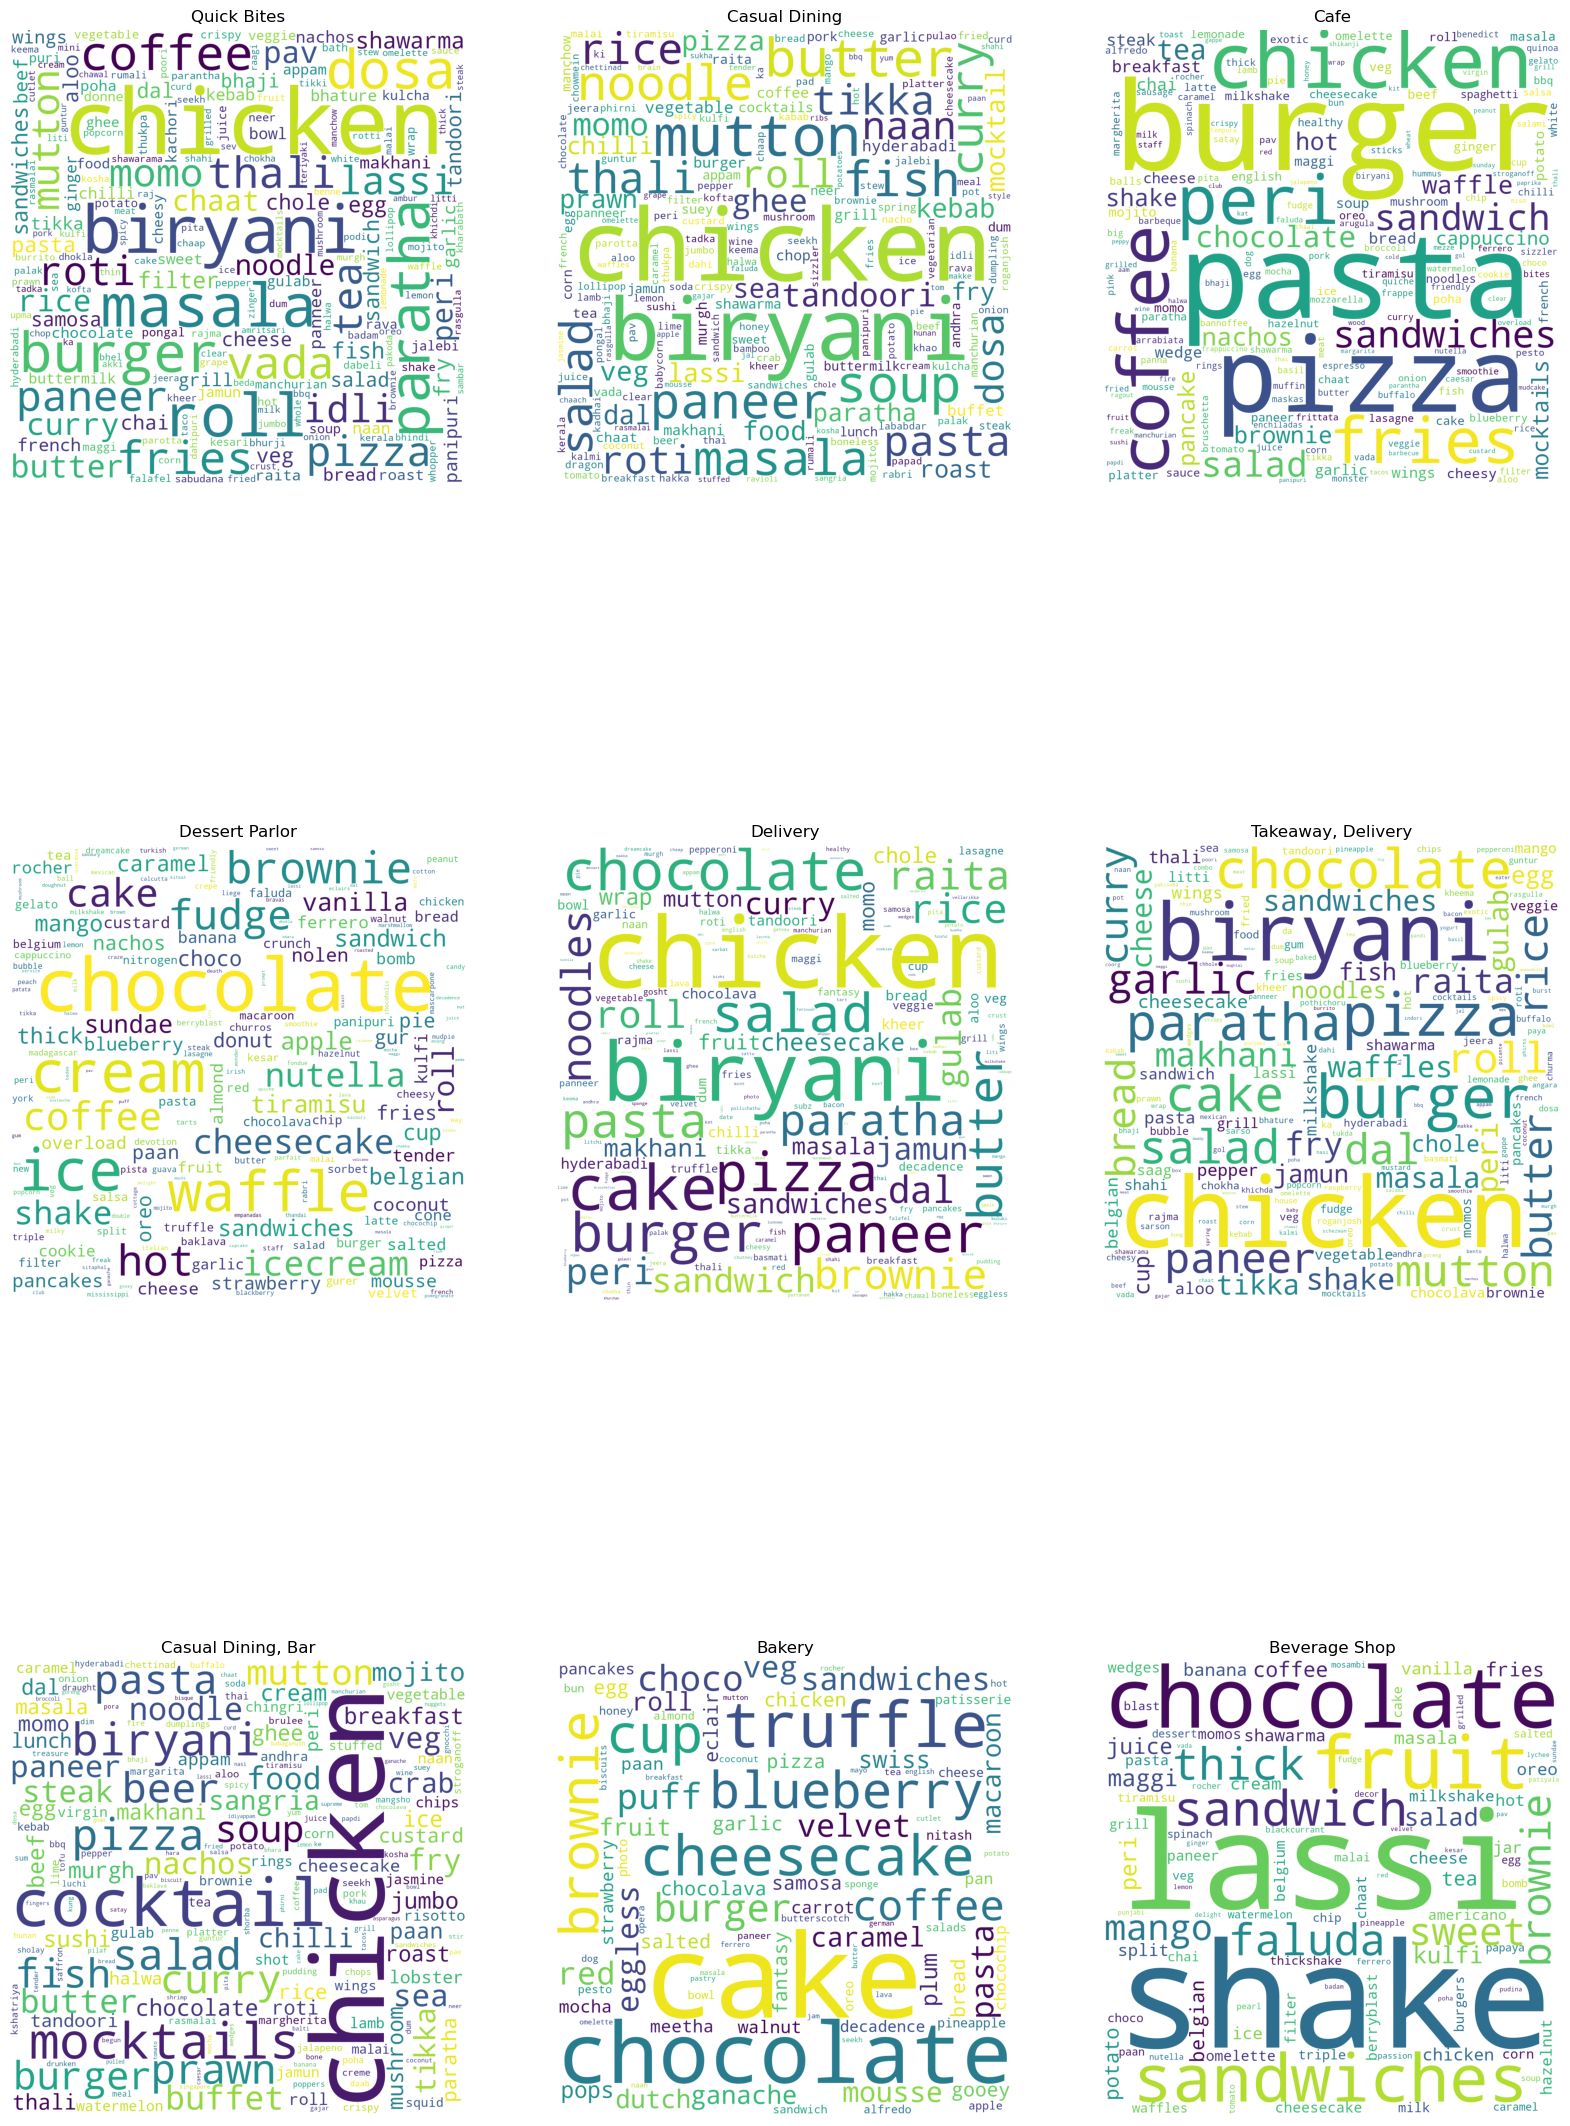

In [63]:
stopwords = set(STOPWORDS) 
produce_wordcloud(rest)

In [64]:
def reviewwords(restaurant):
    dataset=dfupd[dfupd['rest_type']==restaurant]
    total_review=' '
    for review in dataset['reviews_list']:
        review=review.lower()
        review=re.sub('[^a-zA-Z]', ' ',review)
        review=re.sub('rated', ' ',review)
        review=re.sub('x',' ',review)
        review=re.sub(' +',' ',review)
        total_review=total_review + str(review)
    wordcloud = WordCloud(width = 800, height = 800, 
            background_color ='white', 
            stopwords = set(STOPWORDS), 
            min_font_size = 10).generate(total_review) 
    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8)) 
    plt.imshow(wordcloud) 
    plt.axis("off")

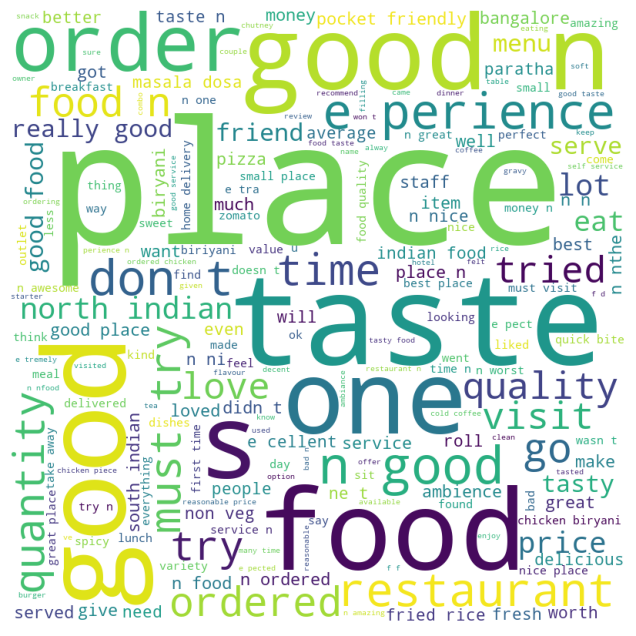

In [65]:
reviewwords('Quick Bites')

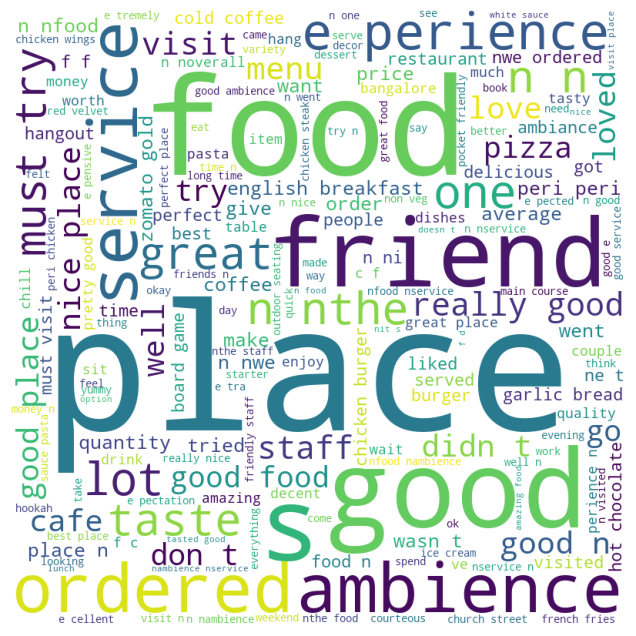

In [66]:
reviewwords('Cafe')

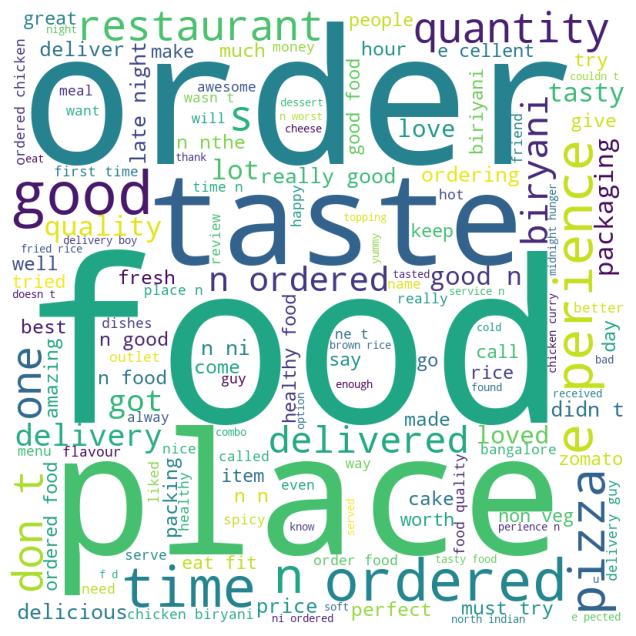

In [67]:
reviewwords('Delivery')

In [68]:
fig=px.bar(x=df['city'].unique(),y=df['city'].value_counts(),labels=dict(x="City Name",y="Total Count"),color_continuous_scale="Agsunset",color=df['city'].unique())
fig.update_layout(title="Location wise counts for Restaurants ",
                  titlefont={'size': 30},template='simple_white'     
                  )
fig.update_traces(marker_line_color='black',
                  marker_line_width=2, opacity=1)
fig.show()

In [69]:
df2=df.copy()
df2.dropna(how='any',inplace=True)

In [70]:
loc_plt=pd.crosstab(df2['rating'],df2['city'])
fig=px.bar(loc_plt,x=loc_plt.index,y=loc_plt.columns,barmode='stack',opacity=1)
fig.update_layout(title="Location wise Rating",
                  titlefont={'size': 30},
                  template='simple_white'       
                  )
fig.update_traces(marker_line_color='black',
                  marker_line_width=0.5, opacity=0.8)
fig.show()

In [71]:
fig=px.histogram(df['type'],labels=dict(value='Type'))
fig.update_layout(title="Type of Services",
                  titlefont={'size': 30},template='simple_white'     
                  )
fig.update_traces(marker_color='darkorange', marker_line_color='black',
                  marker_line_width=2, opacity=1)

fig.show()

In [72]:
fig=px.histogram(df['cost'],labels=dict(value='Cost Range'),nbins=10)
fig.update_layout(title="Cost of Restaurants",
                  titlefont={'size': 30},template='simple_white'     
                  )
fig.update_traces(marker_color='darkorange', marker_line_color='black',
                  marker_line_width=2, opacity=1)

fig.show()

In [73]:
chains=df['name'].value_counts()[:10]
fig=px.bar(y=chains,x=chains.index,labels=dict(x='Name',y='Count'),color_continuous_scale="Agsunset",color=chains.index)
fig.update_layout(title="Most famous restaurant chains",
                  titlefont={'size': 30},template='simple_white'     
                  )
fig.update_traces( marker_line_color='black',
                  marker_line_width=2, opacity=1)

fig.show()